# Donor Propensity Model

This notebook uses a Random Forest Classifier to find individuals who have a high potential to donate. 

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline           # works with imbalanced‑learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Part 1: Import and Clean Data

In [59]:
contacts_df = pd.read_csv(r"C:\Users\maxwell.bicking\donation_data_syn.csv")

#import median income by zip code data from Census Bureau
census_df = pd.read_csv(r"C:\Users\maxwell.bicking\data-science-portfolio\Donor Propensity\Median Income by ZIP.csv")

census_df['ZIP'] = census_df['Geographic Area Name'].str.strip().str[-5:] #add zip column to join to contact table

df = contacts_df.merge(
    census_df[['ZIP', 'Median Income']],
    left_on='ZIP_CODE',
    right_on='ZIP',
    how='left'
)

df = df.drop(columns=['ZIP', 'CHURNED', 'Unnamed: 0'])

In [6]:
df.head(10)

,Unnamed: 0,COUNTRY,AGE,EMAIL_OPT_OUT,CALL_OPT_OUT,DAYS_SINCE_CREATED,DAYS_SINCE_MODIFIED,DAYS_SINCE_LAST_ACTIVITY,HOME_CALL_OPT_OUT,MOBILE_CALL_OPT_OUT,...,TOTAL_DONATION_AMOUNT,TOTAL_DONATIONS,TOTAL_DONATION_AMOUNT_LY,TOTAL_DONATIONS_LY,ASSOCIATED_WITH_MEMBERSHIP,TITLE_CHANGE,PUSHED,CHURNED,ZIP_CODE,Median Income
0,0,United States,NaN,True,False,2314,54,1331.0,False,False,...,41.70,3,4.15,1,0,0,0,0,92130,201731
1,1,United States,NaN,True,False,2326,34,NaN,False,False,...,0.03,1,1.28,1,0,0,0,0,27157,NaN
2,2,United States,NaN,True,False,2381,96,NaN,False,False,...,3.22,2,3.80,1,0,0,1,0,21201,44722
3,3,United States,NaN,True,False,665,57,714.0,False,False,...,0.00,0,0.28,1,1,0,0,0,33612,43919
4,4,United States,NaN,True,False,2020,27,281.0,False,False,...,0.00,0,0.00,1,0,0,0,0,46202,61082
5,5,United States,30.0,True,False,2301,36,NaN,False,False,...,0.00,1,0.00,1,0,0,0,0,40536,NaN
6,6,NaN,NaN,True,False,2312,57,666.0,False,False,...,0.00,1,0.01,1,0,0,0,0,60612,60457
7,7,United States,NaN,True,False,2025,50,1238.0,False,False,...,0.05,1,0.00,1,0,0,0,0,92115,75178
8,8,United States,NaN,True,False,2333,40,196.0,False,False,...,0.00,0,4.26,1,0,0,0,1,92130,201731
9,9,United States,NaN,True,False,2239,31,1272.0,False,False,...,0.00,1,0.00,1,0,1,0,0,30322,NaN


In [79]:
unknown_cols = [
    "GENDER", "RACE", "COUNTRY", "ZIP_CODE",
    "INCOME_LEVEL", "INSTITUTION_TYPE", "PRIMARY_RESEARCH_AREA",
    "HIGHEST_DEGREE", "POLITICAL_PARTY", "Median Income"
]

nonmember_cols = ["MEMBER_TYPE", "MEMBERSHIP_STATUS"]

# Replace NaNs
df[unknown_cols]   = df[unknown_cols].fillna("Unknown")
df[nonmember_cols] = df[nonmember_cols].fillna("Nonmember")

df['DONATED_LY_FLAG'] = (df['TOTAL_DONATIONS_LY'].fillna(0) > 0).astype(int)

df['IS_TOP_DONOR'] = (df['TOTAL_DONATION_AMOUNT'] > 500).fillna(0).astype(int)

df['NET_WORTH_QUARTILE'] = pd.qcut(df['NET_WORTH'], q=4, labels=[1, 2, 3, 4])
df['NET_WORTH_QUARTILE'] = df['NET_WORTH_QUARTILE'].astype(int)

In [77]:
df['IS_TOP_DONOR'].value_counts()

IS_TOP_DONOR
0    85185
1      186
Name: count, dtype: int64

In [42]:
#--- Identify Numeric and Categorical Columns ---
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['AGE', 'DAYS_SINCE_CREATED', 'DAYS_SINCE_MODIFIED', 'DAYS_SINCE_LAST_ACTIVITY', 'DAYS_SINCE_JOINED', 'NET_WORTH', 'DAYS_SINCE_LAST_EVENT', 'TOTAL_MEETING_PAID_AMOUNT', 'TOTAL_NUMBER_OF_EVENTS_ATTENDED', 'TOTAL_MEETING_PAID_AMOUNT_LY', 'TOTAL_EVENTS_LY', 'LAST_DONATION_AMOUNT', 'DAYS_SINCE_LAST_DONATION', 'TOTAL_DONATION_AMOUNT', 'TOTAL_DONATIONS', 'TOTAL_DONATION_AMOUNT_LY', 'TOTAL_DONATIONS_LY', 'ASSOCIATED_WITH_MEMBERSHIP', 'TITLE_CHANGE', 'PUSHED', 'DONATED_LY_FLAG', 'NET_WORTH_QUARTILE']
Categorical columns: ['COUNTRY', 'GENDER', 'INCOME_LEVEL', 'INSTITUTION_TYPE', 'MEMBER_TYPE', 'MEMBERSHIP_STATUS', 'PRIMARY_RESEARCH_AREA', 'RACE', 'HIGHEST_DEGREE', 'POLITICAL_PARTY', 'ZIP_CODE', 'Median Income']


In [64]:
max_cols = df[['DAYS_SINCE_LAST_ACTIVITY', 'DAYS_SINCE_JOINED', 'DAYS_SINCE_LAST_EVENT', 'DAYS_SINCE_LAST_DONATION']]

# age: median

for col in max_cols:
    max = df[col].max()
    df[col].fillna(max, inplace = True)

median_age = df['AGE'].median()
df['AGE'].fillna(median_age, inplace = True)

C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_29448\40960526.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(max, inplace = True)
C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_29448\40960526.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [65]:
df.isna().sum()

COUNTRY                            0
AGE                                0
EMAIL_OPT_OUT                      0
CALL_OPT_OUT                       0
DAYS_SINCE_CREATED                 0
DAYS_SINCE_MODIFIED                0
DAYS_SINCE_LAST_ACTIVITY           0
HOME_CALL_OPT_OUT                  0
MOBILE_CALL_OPT_OUT                0
OTHER_CALL_OPT_OUT                 0
PERSONAL_EMAIL_OPT_OUT             0
WORK_CALL_OPT_OUT                  0
WORK_EMAIL_OPT_OUT                 0
DECEASED                           0
GENDER                             0
INCOME_LEVEL                       0
DAYS_SINCE_JOINED                  0
INSTITUTION_TYPE                   0
MEMBER_TYPE                        0
MEMBERSHIP_STATUS                  0
PRIMARY_RESEARCH_AREA              0
RACE                               0
DO_NOT_EMAIL                       0
PRE_POST_DOC                       0
HIGHEST_DEGREE                     0
NET_WORTH                          0
SMALL_BUSINESS_OWNER               0
I

# Part 2: Data Preprocessing

In [ ]:
#Define the target column and determine feature columns.
#We predict "top_donor" (assumed to be 0/1 or similar).
target_column = "IS_TOP_DONOR"
drop_columns = ["ZIP_CODE"]          # add more if needed
leakage_cols = [
    'TOTAL_DONATION_AMOUNT', 'MOST_RECENT_DONATION_AMOUNT',
    'TOTAL_OPPORTUNITIES', 'TOTAL_AMOUNT_LAST_YEAR',
    'TOTAL_OPPORTUNITIES_LAST_YEAR', 'DONATION_QUARTILE'
]


X = df.drop(columns=[target_column] + drop_columns + leakage_cols).copy()
y = df[target_column]

# --- 2. Identify column groups dynamically -----------------------------------
# A. booleans → convert to numeric 0/1 so they behave like numerics
bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype(int)

# B. categorical (object or pandas "category" dtype)
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# C. numeric (everything else that is already number‑like)
numerical_cols = X.select_dtypes(include=["number"]).columns.difference(bool_cols).tolist()


"""
#Define the target column and determine feature columns.
#We predict "top_donor" (assumed to be 0/1 or similar).
target_column = 'IS_TOP_DONOR'

#Remove the target column from the list of features.
#We might choose to drop columns that are not predictive or have too many unique values (e.g., MAILING_ZIP_CODE)
drop_columns = ['MAILING_ZIP_CODE']  #add others if needed

#Separate features and target
X = df.drop(columns=[target_column] + drop_columns)
y = df[target_column]

#Identify lists for categorical and numerical columns.
categorical_cols = [
    'COUNTRY', 'GENDER', 'INCOME_LEVEL', 'INSTITUTION_TYPE', 
    'MEMBER_TYPE', 'MEMBERSHIP_STATUS', 'PRIMARY_RESEARCH_AREA',
    'RACE', 'POLITICAL_PARTY', 'HIGHEST_DEGREE', 'Median Income'
]

#The remaining columns (or explicitly defined ones) are numerical or boolean.
numerical_cols = [col for col in X.columns if col not in categorical_cols]

#If there are boolean columns in categorical_cols, they may be left as numerical.
#make sure data types are correct:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


# Fill missing values.
# For numerical features, we can fill with the median.
# For categorical features, fill with a constant such as 'missing'.
for col in numerical_cols:
    X[col].fillna(X[col].median(), inplace=True)
for col in categorical_cols:
    X[col].fillna('missing', inplace=True)
"""

'\n\n#Define the target column and determine feature columns.\n#We predict "top_donor" (assumed to be 0/1 or similar).\ntarget_column = \'IS_TOP_DONOR\'\n\n#Remove the target column from the list of features.\n#We might choose to drop columns that are not predictive or have too many unique values (e.g., MAILING_ZIP_CODE)\ndrop_columns = [\'MAILING_ZIP_CODE\']  #add others if needed\n\n#Separate features and target\nX = df.drop(columns=[target_column] + drop_columns)\ny = df[target_column]\n\n#Identify lists for categorical and numerical columns.\ncategorical_cols = [\n    \'COUNTRY\', \'GENDER\', \'INCOME_LEVEL\', \'INSTITUTION_TYPE\', \n    \'MEMBER_TYPE\', \'MEMBERSHIP_STATUS\', \'PRIMARY_RESEARCH_AREA\',\n    \'RACE\', \'POLITICAL_PARTY\', \'HIGHEST_DEGREE\', \'Median Income\'\n]\n\n#The remaining columns (or explicitly defined ones) are numerical or boolean.\nnumerical_cols = [col for col in X.columns if col not in categorical_cols]\n\n#If there are boolean columns in categorical_c

# Part 3: Feature Engineering

In [89]:
# We will create a ColumnTransformer that:
# - One-hot encodes categorical columns.
# - Scales numerical columns.

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])


# Part 4: Building and Training Predictive Model

In [ ]:
#Split Data into Training and Test Sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# 3.  Balanced forest + pipeline
clf = BalancedRandomForestClassifier(
    n_estimators=400,
    random_state=42,
    sampling_strategy='auto')       # down‑samples majority each tree

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', clf)
])

pipe.fit(X_train, y_train)

# 4.  Pick threshold on validation set
val_proba = pipe.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
f1 = 2*precision*recall/(precision+recall+1e-9)
best_thresh = thresholds[f1.argmax()]

print(f"Chosen threshold = {best_thresh:0.3f}")

# Part 5: Evaluation

In [ ]:
test_proba = pipe.predict_proba(X_test)[:,1]
test_pred  = (test_proba >= best_thresh).astype(int)

print(classification_report(y_test, test_pred))
print("PR‑AUC:", average_precision_score(y_test, test_proba))




'''
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', clf)
])

pipe.fit(X_train, y_train)

#Hyperparameter tuning via GridSearchCV.
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best ROC-AUC score from GridSearchCV:", grid_search.best_score_)

#Use the best estimator for evaluation
model = grid_search.best_estimator_
'''

Chosen threshold = 0.820
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17038
           1       0.74      0.68      0.70        37

    accuracy                           1.00     17075
   macro avg       0.87      0.84      0.85     17075
weighted avg       1.00      1.00      1.00     17075

PR‑AUC: 0.8095137776522194


'\npipe = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', clf)\n])\n\npipe.fit(X_train, y_train)\n\n#Hyperparameter tuning via GridSearchCV.\nparam_grid = {\n    \'classifier__n_estimators\': [100, 200],\n    \'classifier__max_depth\': [None, 10, 20],\n    \'classifier__min_samples_split\': [2, 5]\n}\n\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=\'roc_auc\', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nprint("Best parameters from GridSearchCV:", grid_search.best_params_)\nprint("Best ROC-AUC score from GridSearchCV:", grid_search.best_score_)\n\n#Use the best estimator for evaluation\nmodel = grid_search.best_estimator_\n'

Verify PR-AUC score is accurate

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba_cv = cross_val_predict(pipe, X, y, cv=cv,
                             method='predict_proba', n_jobs=-1)[:, 1]

print("PR‑AUC (5‑fold):", average_precision_score(y, proba_cv))

PR‑AUC (5‑fold): 0.7181013600048745


Plot Hold-Out Curve

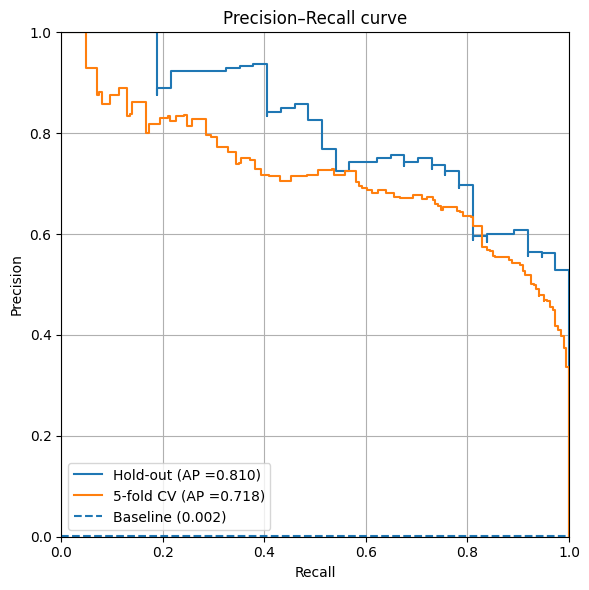

In [98]:
# CONFIGURATION  – edit the variable names if they differ in your NB
# ------------------------------------------------------------------
# 1) Pipeline already trained on TRAIN data
#    (example variable name from earlier messages)
fitted_pipe = pipe

# 2) Hold‑out test data
X_test_split = X_test
y_test_split = y_test

# 3) Full feature matrix / labels for CV (usually the entire df)
X_full = X
y_full = y

# 4) Number of CV folds
n_folds = 5
# ------------------------------------------------------------------

def plot_pr_curve(y_true, y_proba, label=None):
    """Draw a single PR curve on the current axes."""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.step(recall, precision, where="post",
             label=f"{label} (AP ={ap:0.3f})")

# ============== 1. HOLD‑OUT PR CURVE ==============================
test_proba = fitted_pipe.predict_proba(X_test_split)[:, 1]

plt.figure(figsize=(6, 6))
plot_pr_curve(y_test_split, test_proba, label="Hold‑out")

# ============== 2. 5‑FOLD CV PR CURVE ============================
cv = StratifiedKFold(n_splits=n_folds,
                     shuffle=True,
                     random_state=42)

cv_proba = cross_val_predict(
    fitted_pipe,
    X_full,
    y_full,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

plot_pr_curve(y_full, cv_proba, label=f"{n_folds}-fold CV")

# ============== FINAL TOUCHES =====================================
# Baseline (random classifier) = prevalence of positive class
baseline = y_full.mean()
plt.hlines(baseline, 0, 1, linestyle="--",
           label=f"Baseline ({baseline:0.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Part __: Identifying Potential Top Donors

In [ ]:
# -------------------------------------------------------
# 1)  Pull the "low donors" population
# -------------------------------------------------------
donation_threshold = 10          # ← adjust if needed
low_donors = df[df['TOTAL_DONATION_AMOUNT'] < donation_threshold].copy()

# -------------------------------------------------------
# 2)  Keep exactly the columns the pipeline expects
#     (everything except target + leakage + any drops)
# -------------------------------------------------------
feature_cols = pipe.named_steps['preprocessor'].feature_names_in_
X_low_donors = low_donors[feature_cols]

# -------------------------------------------------------
# 3)  Score the contacts
# -------------------------------------------------------
low_donors['predicted_top_donor_score'] = pipe.predict_proba(X_low_donors)[:, 1]

low_donors['predicted_top_donor_flag'] = (
        low_donors['predicted_top_donor_score'] >= best_thresh).astype(int)

# -------------------------------------------------------
# 4)  Rank the list for fund‑raisers
# -------------------------------------------------------
potential_donors = (
    low_donors
      .sort_values('predicted_top_donor_score', ascending=False)
      .reset_index(drop=True)
)

print("\nTop potential donors from contacts with low donation history:")
display_cols = [
    'predicted_top_donor_score',    # model score
    'TOTAL_DONATION_AMOUNT',        # current giving
    'NET_WORTH',                    # example context fields
    'TOTAL_EVENTS_LY',
    'PRIMARY_RESEARCH_AREA'
]
print(potential_donors[display_cols].head(10))



Top potential donors from contacts with low donation history:
   predicted_top_donor_score  TOTAL_DONATION_AMOUNT  NET_WORTH  \
0                     0.4175                   0.41    1171043   
1                     0.4075                   0.94   14622726   
2                     0.4050                   0.49    1240590   
3                     0.3975                   2.45    1721973   
4                     0.3950                   0.03    2377305   
5                     0.3900                   0.14    1280342   
6                     0.3875                   5.80    1328029   
7                     0.3850                   0.02    1109344   
8                     0.3825                   0.52    1124716   
9                     0.3800                   0.00    1186787   

   TOTAL_EVENTS_LY                              PRIMARY_RESEARCH_AREA  
0                0                                           Genetics  
1                0                                       Cell Biol

In [ ]:
# ---------------------------
# Step 8: Conclusion and Next Steps
# ---------------------------
# The script above demonstrates:
# 1. Data preprocessing including handling missing values, encoding, and scaling.
# 2. Splitting your data into training and test sets.
# 3. Building a predictive model with hyperparameter tuning.
# 4. Evaluating the model's performance using several metrics.
# 5. Using the model to identify contacts who look like top donors but have donated little.
#
# Next steps could include:
# - Further feature engineering and exploration (e.g., clustering analysis on high-probability candidates).
# - Testing additional models and ensemble methods.
# - Validating the model’s predictions with domain experts and iterating.

### Bulk below

In [11]:
# -------- Step 2: Define Target --------
donation_cutoff = df["TOTAL_DONATION_AMOUNT"].quantile(0.90)
df["top_donor"] = (df["TOTAL_DONATION_AMOUNT"] >= donation_cutoff).astype(int)

# -------- Step 3: Feature Engineering --------
df["DONATION_QUARTILE"] = pd.cut(
    df["TOTAL_DONATION_AMOUNT"],
    bins=[-1, 0, 100, 1000, df["TOTAL_DONATION_AMOUNT"].max()],
    labels=[0, 1, 2, 3]  # You can relabel these too
)

In [12]:
df["DONATION_QUARTILE"].describe()
df["DONATION_QUARTILE"].value_counts().head(10)

DONATION_QUARTILE
0    56244
1    22854
2     5480
3      795
Name: count, dtype: int64

In [ ]:
# -------- Step 2: Define Target --------
donation_cutoff = df["TOTAL_DONATION_AMOUNT"].quantile(0.90)
df["top_donor"] = (df["TOTAL_DONATION_AMOUNT"] >= donation_cutoff).astype(int)

# -------- Step 3: Feature Engineering --------
df["donation_bucket"] = pd.qcut(df["TOTAL_DONATION_AMOUNT"], q=5,
                                 labels=["Very Low", "Low", "Medium", "High", "Very High"])

# -------- Step 4: Handle Nulls --------
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != "top_donor"]

df[categorical_cols] = df[categorical_cols].fillna("No Answer")
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# -------- Step 5: Feature Importance --------
le = LabelEncoder()
X_cat = df[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))
chi2_vals, p_vals = chi2(X_cat, df["top_donor"])
chi2_scores = pd.DataFrame({
    "Feature": categorical_cols,
    "Importance": chi2_vals,
    "p_value": p_vals,
    "Method": "Chi2"
})

X_num = df[numerical_cols]
mi_scores = mutual_info_classif(X_num, df["top_donor"])
mi_df = pd.DataFrame({
    "Feature": numerical_cols,
    "Importance": mi_scores,
    "Method": "Mutual_Info"
})

# -------- Step 6: Correlation Heatmap --------
corr_matrix = df[numerical_cols + ["top_donor"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# -------- Step 7: Combine Feature Scores --------
feature_scores = pd.concat([chi2_scores, mi_df])
feature_scores = feature_scores.sort_values("Importance", ascending=False)
print("\nTop Features (Pre-Model):")
print(feature_scores.head(10))

# -------- Step 8: Prepare Data for Modeling --------
X = pd.get_dummies(df.drop(columns=["top_donor", "Unnamed: 0"]), drop_first=True)
y = df["top_donor"]
X = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# -------- Step 9: Train/Test Split --------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# -------- Step 10: Train Model --------
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# -------- Step 11: Evaluate --------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# -------- Step 12: Feature Importance Plot --------
model_feature_importance = pd.Series(model.feature_importances_, index=X.columns)
model_top_features = model_feature_importance.sort_values(ascending=False).head(10)

print("\nTop Features (Model-Based):")
print(model_top_features)

model_top_features.plot(kind="barh", title="Top 10 Features (Random Forest)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()